# Import Library

In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from keras.layers import Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Read Data

In [259]:
df = pd.read_parquet("dataset_1B.parquet")
df

,date,quarter,day,Team Code,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,productivity_score
0,1/1/2015,Quarter1,Thursday,8,26.16,1108.0,7080,98,0.0,0,0,59.0,94.073
1,1/1/2015,Quarter1,Thursday,1,3.94,NaN,960,0,0.0,0,0,8.0,88.650
2,1/1/2015,Quarter1,Thursday,11,11.41,968.0,3660,50,0.0,0,0,30.5,80.057
3,1/1/2015,Quarter1,Thursday,12,11.41,968.0,3660,50,0.0,0,0,30.5,80.057
4,1/1/2015,Quarter1,Thursday,6,25.90,1170.0,1920,50,0.0,0,0,56.0,80.038
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,2016-03-10,Quarter2,Wednesday,10,2.90,NaN,960,0,0.0,0,0,8.0,62.833
1193,2016-03-10,Quarter2,Wednesday,8,3.90,NaN,960,0,0.0,0,0,8.0,62.562
1194,2016-03-10,Quarter2,Wednesday,7,3.90,NaN,960,0,0.0,0,0,8.0,62.562
1195,2016-03-10,Quarter2,Wednesday,9,2.90,NaN,1800,0,0.0,0,0,15.0,50.589


In [220]:
df.shape

(1197, 13)

In [221]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                1197 non-null   object 
 1   quarter             1197 non-null   object 
 2   day                 1197 non-null   object 
 3   Team Code           1197 non-null   int64  
 4   smv                 1197 non-null   float64
 5   wip                 691 non-null    float64
 6   over_time           1197 non-null   int64  
 7   incentive           1197 non-null   int64  
 8   idle_time           1197 non-null   float64
 9   idle_men            1197 non-null   int64  
 10  no_of_style_change  1197 non-null   int64  
 11  no_of_workers       1197 non-null   float64
 12  productivity_score  1197 non-null   float64
dtypes: float64(5), int64(5), object(3)
memory usage: 121.7+ KB


# a. Pre-Processing + EDA

## Pre-Process (Pt 1)

In [222]:
df.replace("\\N", pd.NA, inplace=True)

In [223]:
df = df.drop('date', axis=1) #kolom 'date' di drop karena sudah ada 'quarter' dan 'day' yang sudah mewakili waktu

In [224]:
df = df.drop_duplicates().reset_index(drop=True) # Membuang Data Duplikat

#Memisahkan kolom Kategorikal dan Numerikal
cat_cols = []
num_cols = []

for i in df.columns:
    if 'int' in str(df[i].dtype) or 'float' in str(df[i].dtype):
        num_cols.append(i)
    else:
        cat_cols.append(i)

print(cat_cols)
print(num_cols)

['quarter', 'day']
['Team Code', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers', 'productivity_score']


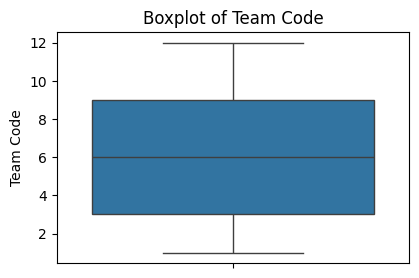

Skewness: 0.009847502796713321
Kurtosis: -1.2239057391150918


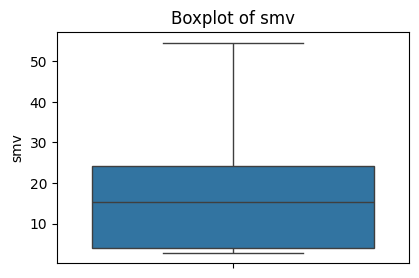

Skewness: 0.40593673685873205
Kurtosis: -0.7953459064328552


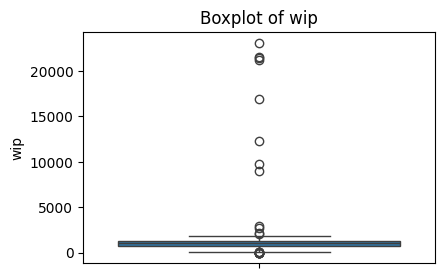

Skewness: 9.741786273952965
Kurtosis: 101.70204486558634


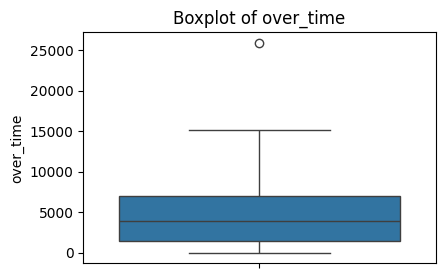

Skewness: 0.6732872952976457
Kurtosis: 0.4243642959188558


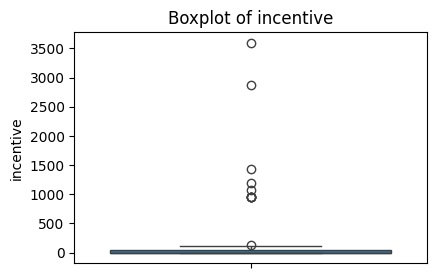

Skewness: 15.790746016958247
Kurtosis: 299.0324620996891


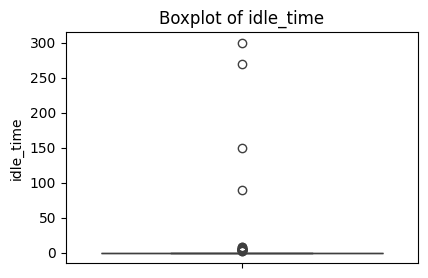

Skewness: 20.545425229670172
Kurtosis: 442.63816033937803


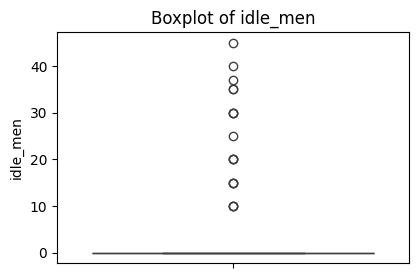

Skewness: 9.855079123524012
Kurtosis: 102.96286931944574


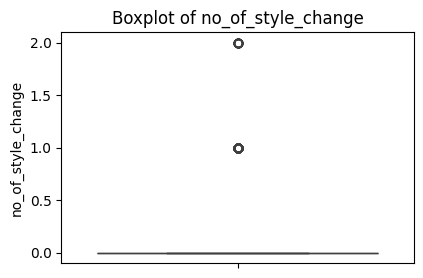

Skewness: 2.9425059460671514
Kurtosis: 8.18149032192787


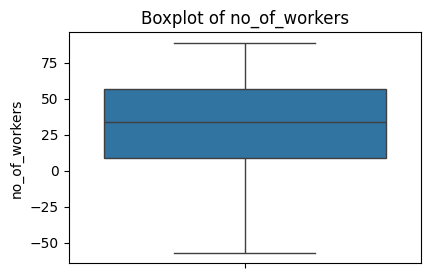

Skewness: -0.21058041534228544
Kurtosis: -1.367593541695826


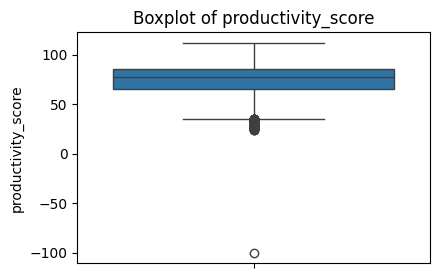

Skewness: -1.4244665308995308
Kurtosis: 6.808535124065298


In [225]:
def check_distribution_outliers(df, columns): #Mengecek apakah ada outlier atau tidak
    for col in columns:
        plt.figure(figsize=(10, 3))
        # Boxplot
        plt.subplot(1, 2, 2)
        sns.boxplot(y=df[col])
        plt.title(f'Boxplot of {col}')

        plt.show()

        print('Skewness:', df[col].skew())
        print('Kurtosis:', df[col].kurt())

check_distribution_outliers(df[num_cols], num_cols)

In [226]:
df.isnull().sum()

,0
quarter,0
day,0
Team Code,0
smv,0
wip,506
over_time,0
incentive,0
idle_time,0
idle_men,0
no_of_style_change,0


In [227]:
#impute wip with median
median = df['wip'].median()
df['wip'].fillna(median, inplace=True)

<ipython-input-227-d2eaca28eb15>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['wip'].fillna(median, inplace=True)


In [228]:
df.isnull().sum()

,0
quarter,0
day,0
Team Code,0
smv,0
wip,0
over_time,0
incentive,0
idle_time,0
idle_men,0
no_of_style_change,0


In [229]:
df['day'].unique()

array(['Thursday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday'],
      dtype=object)

In [230]:
#unique value of quarter
df['quarter'].unique()

array(['Quarter1', 'Quarter2', 'Quarter3', 'Quarter4', 'Quarter5'],
      dtype=object)

In [231]:
#tambahin order buat ordinal
quarter_order = ['Quarter1', 'Quarter2', 'Quarter3', 'Quarter4', 'Quarter5']
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [232]:
#Ini kolom kategorikal yang mau diencode
ordinal_cols = ['quarter', 'day']

#Inisialisasi encoder
ordinal_encoder = OrdinalEncoder(categories=[quarter_order, day_order])

#Fit encoder
df[ordinal_cols] = ordinal_encoder.fit_transform(df[ordinal_cols])


In [233]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   quarter             1197 non-null   float64
 1   day                 1197 non-null   float64
 2   Team Code           1197 non-null   int64  
 3   smv                 1197 non-null   float64
 4   wip                 1197 non-null   float64
 5   over_time           1197 non-null   int64  
 6   incentive           1197 non-null   int64  
 7   idle_time           1197 non-null   float64
 8   idle_men            1197 non-null   int64  
 9   no_of_style_change  1197 non-null   int64  
 10  no_of_workers       1197 non-null   float64
 11  productivity_score  1197 non-null   float64
dtypes: float64(7), int64(5)
memory usage: 112.3 KB


## Split Data

In [234]:
# split target dan variabel kolom 70:10:20.
X = df.drop(columns=['productivity_score'])
y = df['productivity_score']

In [235]:
# split train, test, val
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42) # 0.33*0.3 = 0.1

## EDA

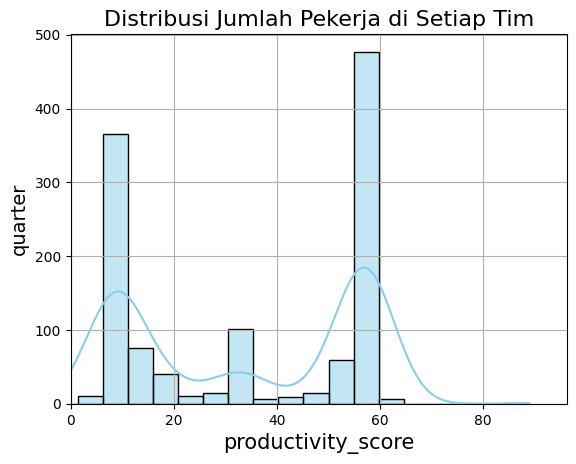

In [236]:
#Histogram distribusi jumlah pekerja
sns.histplot(df['no_of_workers'], kde=True, bins=30, color='skyblue')

plt.xlabel("productivity_score", fontsize=15)
plt.ylabel("quarter", fontsize=14)
plt.xlim(left=0)
plt.grid(True)
plt.title("Distribusi Jumlah Pekerja di Setiap Tim", fontsize=16)
plt.show()

Kesimpulan:

Bisa diilihat kalau puncak distribusi plot tersebut ada di sekitar 45 dan 60.
dan hampir tidak ada tim yang punya jumlah pekerja di bawah 10 atau di atas 70.

X-axis menunjukan jumlah pekerja dalam satu tim

Y-axis menunjukkan berapa banyak tim yang memiliki jumlah pekerja.


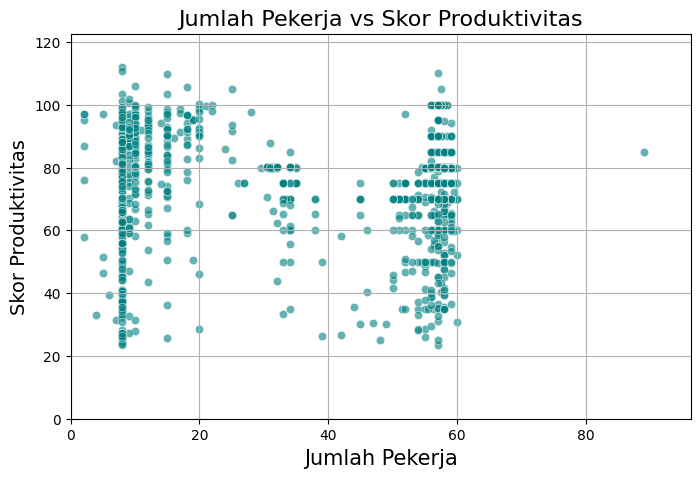

In [237]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='no_of_workers', y='productivity_score', data=df, color='teal', alpha=0.6)

plt.xlabel("Jumlah Pekerja", fontsize=15)
plt.ylabel("Skor Produktivitas", fontsize=14)
plt.title("Jumlah Pekerja vs Skor Produktivitas", fontsize=16)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.grid(True)
plt.show()

Scatter plot nunjukkin apakah semakin banyak pekerja, makin tinggi produktivitas, atau justru nggak ada hubungan. Misalnya, kalau titik-titiknya naik seiring jumlah pekerja naik, berarti ada korelasi positif.

In [238]:
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val  :", X_val.shape)
print("y_val  :", y_val.shape)
print("X_test :", X_test.shape)
print("y_test :", y_test.shape)

X_train: (837, 11)
y_train: (837,)
X_val  : (241, 11)
y_val  : (241,)
X_test : (119, 11)
y_test : (119,)


In [239]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   quarter             1197 non-null   float64
 1   day                 1197 non-null   float64
 2   Team Code           1197 non-null   int64  
 3   smv                 1197 non-null   float64
 4   wip                 1197 non-null   float64
 5   over_time           1197 non-null   int64  
 6   incentive           1197 non-null   int64  
 7   idle_time           1197 non-null   float64
 8   idle_men            1197 non-null   int64  
 9   no_of_style_change  1197 non-null   int64  
 10  no_of_workers       1197 non-null   float64
 11  productivity_score  1197 non-null   float64
dtypes: float64(7), int64(5)
memory usage: 112.3 KB


# b. Baseline Model with Evaluation

## Sequential

In [240]:
#normalization
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

In [241]:
#Fit hanya ke data training, transform semuanya
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

In [242]:
print("X_train:", X_train_scaled.shape)
print("y_train:", y_train_scaled.shape)
print("X_val  :", X_val_scaled.shape)
print("y_val  :", y_val_scaled.shape)
print("X_test :", X_test_scaled.shape)
print("y_test :", y_test_scaled.shape)

X_train: (837, 11)
y_train: (837,)
X_val  : (241, 11)
y_val  : (241,)
X_test : (119, 11)
y_test : (119,)


In [243]:
n_features = X_train_scaled.shape[1]
n_features

11

In [244]:
# cek max and min in y_test_scaled, y_train_scaled, y_val_scaled untuk memastikan sudah benar
print("y_test_scaled:", y_test_scaled.min(), y_test_scaled.max())
print("y_train_scaled:", y_train_scaled.min(), y_train_scaled.max())
print("y_val_scaled:", y_val_scaled.min(), y_val_scaled.max())

y_test_scaled: -1.391302876862179 0.8867298952330472
y_train_scaled: 0.0 0.9999999999999999
y_val_scaled: 0.028949060029546725 0.9774903296381087


In [245]:
# cek max and min di setiap X_train_scaled_ X_test_scaled, X_val_scaled
print("X_test_scaled:", X_test_scaled.min(axis=0), X_test_scaled.max(axis=0))
print("X_train_scaled:", X_train_scaled.min(axis=0), X_train_scaled.max(axis=0))
print("X_val_scaled:", X_val_scaled.min(axis=0), X_val_scaled.max(axis=0))

X_test_scaled: [-1.13676384 -1.32766305 -1.52131547 -1.07918481 -0.73652607 -1.33341366
 -0.22303708 -0.04631125 -0.1131498  -0.36034082 -1.24572521] [2.15267897 1.52536384 1.63833974 1.38072175 1.20060309 1.83875933
 0.37942101 1.20099753 9.51800789 4.31570981 1.15744958]
X_train_scaled: [-1.13676384 -1.32766305 -1.52131547 -1.07918481 -0.73457398 -1.33341366
 -0.22303708 -0.04631125 -0.1131498  -0.36034082 -3.95475861] [ 2.15267897  1.52536384  1.63833974  3.2726793  14.30436767  6.40883905
 18.97031794 28.73773771 12.72839379  4.31570981  1.15744958]
X_val_scaled: [-1.13676384 -1.32766305 -1.52131547 -1.07918481 -0.73197119 -1.33341366
 -0.22303708 -0.04631125 -0.1131498  -0.36034082 -1.81374834] [ 2.15267897  1.52536384  1.63833974  3.5928289  10.24400959  3.18290042
  4.89519093 57.52178667 14.33358674  4.31570981  2.4245781 ]


In [246]:
import numpy as np
# cek sebelum dimasukkn ke model
print("NaN in X_train_scaled:", np.any(np.isnan(X_train_scaled)))
print("Inf in X_train_scaled:", np.any(np.isinf(X_train_scaled)))

print("NaN in X_val_scaled:", np.any(np.isnan(X_val_scaled)))
print("Inf in X_val_scaled:", np.any(np.isinf(X_val_scaled)))

print("NaN in X_test_scaled:", np.any(np.isnan(X_test_scaled)))
print("Inf in X_test_scaled:", np.any(np.isinf(X_test_scaled)))

print("NaN in y_train_scaled:", np.any(np.isnan(y_train_scaled)))
print("Inf in y_train_scaled:", np.any(np.isinf(y_train_scaled)))

print("NaN in y_val_scaled:", np.any(np.isnan(y_val_scaled)))
print("Inf in y_val_scaled:", np.any(np.isinf(y_val_scaled)))

print("NaN in y_test_scaled:", np.any(np.isnan(y_test_scaled)))
print("Inf in y_test_scaled:", np.any(np.isinf(y_test_scaled)))

NaN in X_train_scaled: False
Inf in X_train_scaled: False
NaN in X_val_scaled: False
Inf in X_val_scaled: False
NaN in X_test_scaled: False
Inf in X_test_scaled: False
NaN in y_train_scaled: False
Inf in y_train_scaled: False
NaN in y_val_scaled: False
Inf in y_val_scaled: False
NaN in y_test_scaled: False
Inf in y_test_scaled: False


In [247]:
n_features = X_train_scaled.shape[1]
model_sequential_baseline = Sequential([
    Dense(2 * n_features, activation='relu', input_shape=(n_features,)),  # Hidden Layer 1
    Dense(2 * n_features, activation='relu'),                              # Hidden Layer 2
    Dense(1)                                                              # Output Layer (untuk regresi)
])

model_sequential_baseline.compile(optimizer='adam', loss='mse', metrics=['mae'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [248]:
# train model
history_sequential_baseline = model_sequential_baseline.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    batch_size=32,
    verbose=1
)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.1922 - mae: 0.9416 - val_loss: 0.5341 - val_mae: 0.5156
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2734 - mae: 0.4324 - val_loss: 0.1062 - val_mae: 0.2605
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1194 - mae: 0.2803 - val_loss: 0.0790 - val_mae: 0.2116
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0647 - mae: 0.2048 - val_loss: 0.0556 - val_mae: 0.1835
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0574 - mae: 0.1917 - val_loss: 0.0499 - val_mae: 0.1722
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0486 - mae: 0.1758 - val_loss: 0.0481 - val_mae: 0.1673
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0474 - mae: 0.1719 - val_loss: 0.0494 - val_mae: 0.1674
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0441 - mae: 0.1654 - val_loss: 0.0499 - val_mae: 0.1661
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.04

In [249]:
y_pred_scaled = model_sequential_baseline.predict(X_test_scaled).flatten()

y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

mse = mean_squared_error(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, y_pred_original)

print("\nMetrics on original scale:")
print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R-squared: {r2:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Metrics on original scale:
Test MSE: 482.6003
Test MAE: 12.4988
Test RMSE: 21.9682
Test R-squared: 0.1626


## Functional

Perbedaan dengan yang sequential adalah ini menggunakan 3 hidden layer dan neurons 3x lipat dari input dimensions.

In [250]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

inputs = Input(shape=(n_features,))

x = Dense(2 * n_features, activation='relu')(inputs)
x = Dense(2 * n_features, activation='relu')(x)
x = Dense(2 * n_features, activation='relu')(x)

outputs = Dense(1)(x)

model_functional_baseline = Model(inputs=inputs, outputs=outputs)

model_functional_baseline.compile(optimizer='adam', loss='mse', metrics=['mae'])

history_functional_baseline = model_functional_baseline.fit(
    X_train_scaled, y_train_scaled, #y_train jadi y_train_scaled
    validation_data=(X_val_scaled, y_val_scaled), # y_val jadi y_val_scaled
    epochs=10,
    batch_size=32
)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.8673 - mae: 0.7416 - val_loss: 1.8004 - val_mae: 0.4714
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3028 - mae: 0.3047 - val_loss: 0.7651 - val_mae: 0.3261
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0784 - mae: 0.2211 - val_loss: 0.6277 - val_mae: 0.2807
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0564 - mae: 0.1868 - val_loss: 0.2898 - val_mae: 0.2324
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0524 - mae: 0.1776 - val_loss: 0.0637 - val_mae: 0.1874
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0443 - mae: 0.1659 - val_loss: 0.0559 - val_mae: 0.1794
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0419 - mae: 0.1623 - val_loss: 0.0547 - val_mae: 0.1736
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0413 - mae: 0.1567 - val_loss: 0.0471 - val_mae: 0.1648
Epoch 9/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0378 - mae:

In [251]:
y_pred_scaled = model_functional_baseline.predict(X_test_scaled).flatten()

y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

mse = mean_squared_error(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, y_pred_original)

print("\nMetrics on original scale:")
print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R-squared: {r2:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

Metrics on original scale:
Test MSE: 537.4554
Test MAE: 15.0614
Test RMSE: 23.1831
Test R-squared: 0.0674


# C. Modif Model

In [252]:
model_sequential_modif = Sequential([
    Dense(64, activation='relu', input_shape=(n_features,)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])

model_sequential_modif.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='mse',
    metrics=['mae']
)

history_seq_modif = model_sequential_modif.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=20,
    batch_size=16,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.3129 - mae: 0.4839 - val_loss: 0.0563 - val_mae: 0.1901
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0542 - mae: 0.1849 - val_loss: 0.0456 - val_mae: 0.1627
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0397 - mae: 0.1553 - val_loss: 0.0408 - val_mae: 0.1546
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0340 - mae: 0.1420 - val_loss: 0.0379 - val_mae: 0.1461
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0332 - mae: 0.1453 - val_loss: 0.0403 - val_mae: 0.1461
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0315 - mae: 0.1365 - val_loss: 0.0420 - val_mae: 0.1468
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0303 - mae: 0.1330 - val_loss: 0.0525 - val_mae: 0.1531
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0298 - mae: 0.1321 - val_loss: 0.0355 - val_mae: 0.1393
Epoch 9/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0290 - mae: 

In [254]:
from tensorflow.keras.layers import LeakyReLU

inputs = Input(shape=(n_features,))
x = Dense(64)(inputs)
x = LeakyReLU()(x)
x = Dense(32)(x)
x = LeakyReLU()(x)
x = Dense(16)(x)
x = LeakyReLU()(x)
outputs = Dense(1)(x)

model_functional_modif = Model(inputs=inputs, outputs=outputs)

model_functional_modif.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='mse',
    metrics=['mae']
)

history_func_modif = model_functional_modif.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=20,
    batch_size=16,
    verbose=1
)

Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1968 - mae: 0.3518 - val_loss: 0.1639 - val_mae: 0.2126
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0495 - mae: 0.1750 - val_loss: 0.0476 - val_mae: 0.1661
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0387 - mae: 0.1584 - val_loss: 0.0404 - val_mae: 0.1551
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0357 - mae: 0.1503 - val_loss: 0.0405 - val_mae: 0.1509
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0355 - mae: 0.1439 - val_loss: 0.0415 - val_mae: 0.1505
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0345 - mae: 0.1486 - val_loss: 0.0388 - val_mae: 0.1458
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0333 - mae: 0.1405 - val_loss: 0.0443 - val_mae: 0.1513
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0306 - mae: 0.1375 - val_loss: 0.0399 - val_mae: 0.1451
Epoch 9/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0295 - m

# 1.D. Calling all Evaluation

In [255]:
def evaluate_model(model, X_test_scaled, y_test_scaled, model_name="Model"):
    y_pred_scaled = model.predict(X_test_scaled).flatten()
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_true = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"Evaluation for {model_name}")
    print(f"Test MSE       : {mse:.4f}")
    print(f"Test MAE       : {mae:.4f}")
    print(f"Test RMSE      : {rmse:.4f}")
    print(f"Test R-squared : {r2:.4f}")

    return {
        'model': model_name,
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    }

In [256]:
results = []
results.append(evaluate_model(model_sequential_baseline, X_test_scaled, y_test_scaled, "Sequential Baseline"))
results.append(evaluate_model(model_functional_baseline, X_test_scaled, y_test_scaled, "Functional Baseline"))
results.append(evaluate_model(model_sequential_modif, X_test_scaled, y_test_scaled, "Sequential Modified"))
results.append(evaluate_model(model_functional_modif, X_test_scaled, y_test_scaled, "Functional Modified"))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Evaluation for Sequential Baseline
Test MSE       : 482.6003
Test MAE       : 12.4988
Test RMSE      : 21.9682
Test R-squared : 0.1626
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Evaluation for Functional Baseline
Test MSE       : 537.4554
Test MAE       : 15.0614
Test RMSE      : 23.1831
Test R-squared : 0.0674
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Evaluation for Sequential Modified
Test MSE       : 512.1017
Test MAE       : 13.2037
Test RMSE      : 22.6297
Test R-squared : 0.1114
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Evaluation for Functional Modified
Test MSE       : 516.2126
Test MAE       : 13.4738
Test RMSE      : 22.7203
Test R-squared : 0.1042


Functional Modified berhasil mengungguli semua model, baik yang baseline maupun modified  